# **このKaggleコンペについて** 　　　「リクルートのレストランの訪問者を予測」

###   ///客の予約時のデータと実際に来店した際のデータを使用して、将来の各レストランに訪れる客の数を予測するというもの\\\

### air: Airレジ（飲食店向けPOSレジアプリ）の情報　/ 　hpg: ホットペッパーの情報

In [1]:
# 与えられたinput用データを確認
# -----------------------------------
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recruit-restaurant-visitor-forecasting/air_reserve.csv.zip
/kaggle/input/recruit-restaurant-visitor-forecasting/hpg_store_info.csv.zip
/kaggle/input/recruit-restaurant-visitor-forecasting/hpg_reserve.csv.zip
/kaggle/input/recruit-restaurant-visitor-forecasting/sample_submission.csv.zip
/kaggle/input/recruit-restaurant-visitor-forecasting/air_visit_data.csv.zip
/kaggle/input/recruit-restaurant-visitor-forecasting/air_store_info.csv.zip
/kaggle/input/recruit-restaurant-visitor-forecasting/date_info.csv.zip
/kaggle/input/recruit-restaurant-visitor-forecasting/store_id_relation.csv.zip


In [2]:
# 基本モジュールをインポートする
# -----------------------------------
import pandas as pd    # data processing(情報処理する)
import numpy as np    # linear algebra(線形の形にする)
import scipy as sp    # Science and Technology Calculation(科学技術計算する)
import matplotlib.pyplot as plt    # 可視化のためのモジュール
%matplotlib inline
import seaborn as sns    # 可視化のためのモジュール
import warnings    # 不要な警告を無視する(出さない)ためのモジュール
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import Image    # 画像表示のためのモジュール

# # 分析のためのモジュールをインポート(SKLEARNはMLのためのモジュール)
# -----------------------------------
from sklearn.preprocessing import StandardScaler    # データの標準化
from sklearn.linear_model import LogisticRegression    # ロジスティック回帰
from sklearn import linear_model    # 回帰
from sklearn.tree import DecisionTreeClassifier    # 決定木
from sklearn.metrics import accuracy_score    # 精度評価
from sklearn.metrics import classification_report,confusion_matrix    # モデルの良し悪しを判断する

# データセットのインポート
# -----------------------------------
air_reserve = pd.read_csv('../input/recruit-restaurant-visitor-forecasting/air_reserve.csv.zip')
air_store = pd.read_csv('../input/recruit-restaurant-visitor-forecasting/air_store_info.csv.zip')
air_visit = pd.read_csv('../input/recruit-restaurant-visitor-forecasting/air_visit_data.csv.zip')
date_info = pd.read_csv('../input/recruit-restaurant-visitor-forecasting/date_info.csv.zip')
hpg_reserve = pd.read_csv('../input/recruit-restaurant-visitor-forecasting/hpg_reserve.csv.zip')
hpg_store = pd.read_csv('../input/recruit-restaurant-visitor-forecasting/hpg_store_info.csv.zip')
sample = pd.read_csv('../input/recruit-restaurant-visitor-forecasting/sample_submission.csv.zip')
store_id_relation = pd.read_csv('../input/recruit-restaurant-visitor-forecasting/store_id_relation.csv.zip')

air_reserve.shape ,air_store.shape ,air_visit.shape ,date_info.shape ,hpg_reserve.shape ,hpg_store.shape ,sample.shape ,store_id_relation.shape

((92378, 4),
 (829, 5),
 (252108, 3),
 (517, 3),
 (2000320, 4),
 (4690, 5),
 (32019, 2),
 (150, 2))

In [3]:
air_reserve.head(3)

#来店者の情報(air)
#  Store id(air_store_id)
#  来店した日時(visit_datetime)
#  予約した日時(reserve_datetime)
#  来店者数(reserve_visitors)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6


In [4]:
air_store.head(3)

#来店者の情報(air)
#  Store id(air_store_id)
#  店舗のジャンル(air_genre_name)
#  場所(air_area_name)
#  緯度 (latitude)
#  経度 (longitude)

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852


In [5]:
air_visit.head(3)

#来店者の情報(air)
#  Store id(air_store_id)
#  日付(visit_date)
#  来店者数(visitors)

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29


In [6]:
date_info.head(3)

#カレンダーの情報(data)
#  カレンダー(calendar_date)
#  曜日(day_of_week)
#  休日かどうか(holiday_flg) (1休日、祝日:,0:平日)

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1


In [7]:
hpg_reserve.head(3)

#予約の情報(hpg)
#  Store id(hpg_store_id)
#  来店した日時(visit_datetime)
#  予約した日時(reserve_datetime)
#  (行く予定の予約日時ではなく予約自体をした日時と思われる)
#  予約した人数(reserve_visitors)

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2


In [8]:
hpg_store.head(3)

#予約の情報(hpg)
#  Store id(hpg_store_id)
#  店舗のジャンル(air_genre_name)
#  場所(air_area_name)
#  緯度 (latitude)
#  経度 (longitude)

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [9]:
sample.head(3)

#提出用ファイルの情報(sample)
#  Store id 日付(id)
#  来店者数(visitors)

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0


In [10]:
store_id_relation.head(3)

#全ストアid(air&hpg)
#  airレストランの来店者数(air_store_id)
#  ホットペッパーの来店者数(hpg_store_id)

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9


In [11]:
# 元々のIDからstore_idとvisit_dateを切り出す(sampleのid部分に時間とidが混在していて見にくいので分ける)

sample['store_id'] = sample['id'].str[:20]    # str[:20]は最初から20文字目までを取得している
sample['visit_date'] = sample['id'].str[21:]

# 日付型へ変換
sample['visit_date'] = pd.to_datetime(sample['visit_date'])

# store_idのカラム名をair_store_idに変える
sample.rename(index = str,columns={'store_id': 'air_store_id'})

# データの表示
sample.head(3)

,id,visitors,store_id,visit_date
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25


In [12]:
# 欠損のチェック

air_reserve.isnull().sum() , air_store.isnull().sum() , air_visit.isnull().sum() , date_info.isnull().sum() , hpg_reserve.isnull().sum() , hpg_store.isnull().sum() , store_id_relation.isnull().sum()

### 欠損値0

(air_store_id        0
 visit_datetime      0
 reserve_datetime    0
 reserve_visitors    0
 dtype: int64,
 air_store_id      0
 air_genre_name    0
 air_area_name     0
 latitude          0
 longitude         0
 dtype: int64,
 air_store_id    0
 visit_date      0
 visitors        0
 dtype: int64,
 calendar_date    0
 day_of_week      0
 holiday_flg      0
 dtype: int64,
 hpg_store_id        0
 visit_datetime      0
 reserve_datetime    0
 reserve_visitors    0
 dtype: int64,
 hpg_store_id      0
 hpg_genre_name    0
 hpg_area_name     0
 latitude          0
 longitude         0
 dtype: int64,
 air_store_id    0
 hpg_store_id    0
 dtype: int64)

Text(0.5, 1.0, 'Visitor and Reservations')

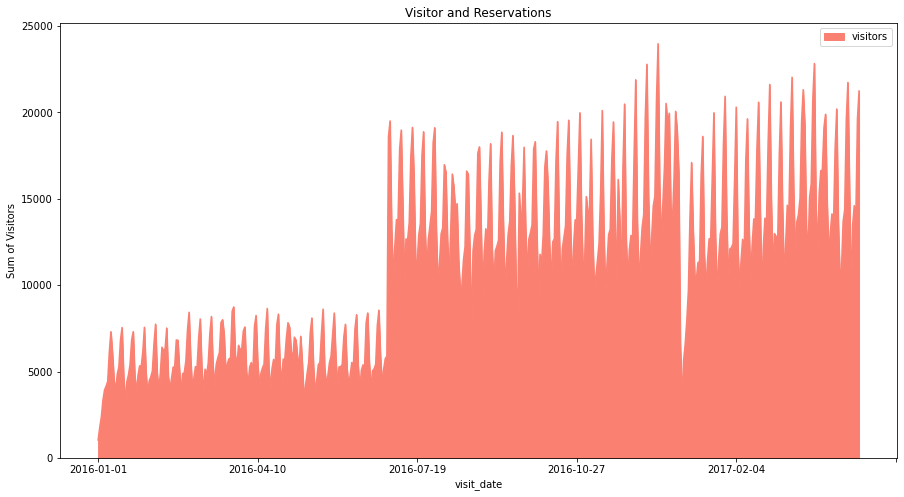

In [13]:
# 来店者数と予約者数を可視化

f,ax = plt.subplots(1,1,figsize=(15,8))
plt1 = air_visit.groupby(['visit_date'], as_index=False).agg({'visitors': np.sum})
plt1=plt1.set_index('visit_date')
plt1.plot(color='salmon', kind='area', ax=ax)
plt.ylabel("Sum of Visitors")
plt.title("Visitor and Reservations")

## 上の図から2016-07から来店者数が上がったことが読み取れる

## なぜか？

# 要因予想：2016年の世界経済を見たときに、2016年前半は世界経済と国際金融市場が大きく動揺し,日本経済と東京市場も例外ではなく、円高・株安になっていた。
# 以上から、1年間のデータしか手元にはないが、毎年前半が来店者数が落ち込むわけではなく、突発的な出来事であり、2016年においては7月以降のデータが例年の来店者数であると推定できる

Text(0, 0.5, 'reserve_visitors')

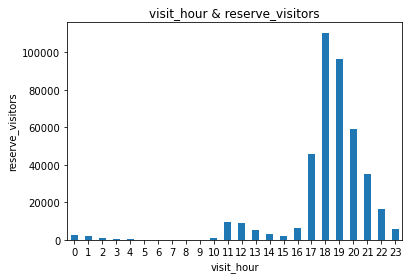

In [14]:
# 来店者数と予約者数を24時間の時間で可視化

air_reserve['visit_hour'] = pd.to_datetime(air_reserve['visit_datetime']).dt.hour    # datetimeからdt.hourで時間だけ取り出して行列化する
air_reserve.groupby('visit_hour')['reserve_visitors'].sum().plot.bar(rot=0)    # pandasのメソッドの一つで、groupby()で指定した列でグルーピングする
plt.title("visit_hour & reserve_visitors")
plt.xlabel("visit_hour")
plt.ylabel("reserve_visitors")



## 下図から17:00-21:00の間に来店者数が多くなっていることが分かる

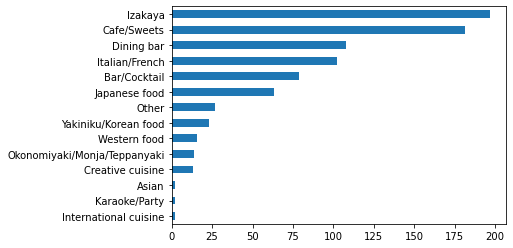

In [15]:
# 店のジャンルを可視化

air_store.air_genre_name.value_counts().sort_values().plot(kind='barh')

## 先ほど述べた、世界経済の落ち込みによる影響を受けやすい居酒屋やバーが上位に来ている

In [16]:
# 予約システムの偏り調査

air = pd.merge(air_reserve,air_store,on='air_store_id')    # pd.merge()関数では第一引数(air_reserve)と第二引数(air_store)に2つを結合するpandas.DataFrame
hpg = pd.merge(hpg_reserve,hpg_store,on='hpg_store_id')    # pandas.DataFrameを縦横に連結するにはpandas.concat()関数
airrel = pd.merge(air,store_id_relation,how='left',on='air_store_id')    # leftなので左から結合
hpgrel = pd.merge(hpg,store_id_relation,how='left',on='hpg_store_id')
full = pd.merge(airrel,hpgrel,how='outer')
print("airのレストランが ",len(air)," 店舗、 ホットペッパーのレストランが ",len(hpg)," 店舗で、そのうち",len(store_id_relation),' 店舗が両方使っている。')

airのレストランが  92378  店舗、 ホットペッパーのレストランが  871308  店舗で、そのうち 150  店舗が両方使っている。


## 予約システムはホットペッパーに偏りがあると得られた

In [17]:
# 店のジャンルををダミー変数化する
air_store = pd.concat([air_store, pd.get_dummies(air_store['air_genre_name'], prefix = 'air_genre_name')], axis=1)
air_store.head(3)

,air_store_id,air_genre_name,air_area_name,latitude,longitude,air_genre_name_Asian,air_genre_name_Bar/Cocktail,air_genre_name_Cafe/Sweets,air_genre_name_Creative cuisine,air_genre_name_Dining bar,air_genre_name_International cuisine,air_genre_name_Italian/French,air_genre_name_Izakaya,air_genre_name_Japanese food,air_genre_name_Karaoke/Party,air_genre_name_Okonomiyaki/Monja/Teppanyaki,air_genre_name_Other,air_genre_name_Western food,air_genre_name_Yakiniku/Korean food
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [18]:
# 休日

date_info.loc[date_info.holiday_flg==1]

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
10,2016-01-11,Monday,1
41,2016-02-11,Thursday,1
79,2016-03-20,Sunday,1
80,2016-03-21,Monday,1
119,2016-04-29,Friday,1
123,2016-05-03,Tuesday,1
124,2016-05-04,Wednesday,1


In [19]:
train = pd.merge(air_reserve,store_id_relation,how="inner",on=["air_store_id"])
train = pd.merge(train,air_store,how="inner",on=["air_store_id"])
train = pd.merge(train,air_visit,how="inner",on=["air_store_id"])
train1 = train.drop(["visit_date","visit_datetime","hpg_store_id","reserve_datetime", "air_genre_name", "air_area_name", "latitude", "longitude","visitors"], axis = 1)
train = train.sample(1000)
train1 = train1.sample(1000)
train

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_hour,hpg_store_id,air_genre_name,air_area_name,latitude,longitude,...,air_genre_name_Italian/French,air_genre_name_Izakaya,air_genre_name_Japanese food,air_genre_name_Karaoke/Party,air_genre_name_Okonomiyaki/Monja/Teppanyaki,air_genre_name_Other,air_genre_name_Western food,air_genre_name_Yakiniku/Korean food,visit_date,visitors
8290624,air_3e93f3c81008696d,2017-04-15 21:00:00,2017-04-14 22:00:00,3,21,hpg_c2a8494d55fafbd6,Okonomiyaki/Monja/Teppanyaki,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018,...,0,0,0,0,1,0,0,0,2017-03-24,42
5216712,air_9241121af22ff1d6,2016-04-30 19:00:00,2016-04-28 21:00:00,2,19,hpg_49dbe1fd79450e55,Izakaya,Tōkyō-to Katsushika-ku Tateishi,35.743575,139.847180,...,0,1,0,0,0,0,0,0,2016-04-21,14
4454362,air_32460819c7600037,2016-04-20 19:00:00,2016-04-13 22:00:00,4,19,hpg_ac318be70910278f,Dining bar,Ōsaka-fu Ōsaka-shi Shinmachi,34.676231,135.486059,...,0,0,0,0,0,0,0,0,2016-02-17,31
4436114,air_32460819c7600037,2016-02-15 19:00:00,2016-02-15 19:00:00,3,19,hpg_ac318be70910278f,Dining bar,Ōsaka-fu Ōsaka-shi Shinmachi,34.676231,135.486059,...,0,0,0,0,0,0,0,0,2016-10-05,57
9988257,air_f8233ad00755c35c,2016-12-26 20:00:00,2016-12-26 15:00:00,4,20,hpg_098e4dd30e54fee6,Italian/French,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,...,1,0,0,0,0,0,0,0,2016-08-29,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555730,air_2cee51fa6fdf6c0d,2017-01-28 21:00:00,2017-01-28 02:00:00,2,21,hpg_113fd6e4fa77800f,Western food,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,...,0,0,0,0,0,0,1,0,2016-07-10,45
10319335,air_bb09595bab7d5cfb,2017-04-22 18:00:00,2017-04-19 17:00:00,3,18,hpg_aea428a1075052bf,Izakaya,Niigata-ken Niigata-shi Teraohigashi,37.874223,138.971940,...,0,1,0,0,0,0,0,0,2016-08-18,25
2783081,air_2aab19554f91ff82,2016-07-08 18:00:00,2016-07-05 11:00:00,2,18,hpg_cac091abfcee2a85,Yakiniku/Korean food,Tōkyō-to Chūō-ku Ginza,35.672114,139.770825,...,0,0,0,0,0,0,0,1,2016-03-03,41
6073894,air_0a74a5408a0b8642,2016-12-29 18:00:00,2016-12-25 21:00:00,2,18,hpg_2ded824e690c414a,Western food,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,...,0,0,0,0,0,0,1,0,2017-02-14,40


In [20]:
# 説明変数と目的変数を指定

# 説明変数のデータを作る
X = train.drop(["air_store_id","visit_date","visit_datetime","hpg_store_id","reserve_datetime", "air_genre_name", "air_area_name", "latitude", "longitude","visitors"], axis = 1)

# 目的変数のデータを作る
y = train['visitors'].values 

In [21]:
X

,reserve_visitors,visit_hour,air_genre_name_Asian,air_genre_name_Bar/Cocktail,air_genre_name_Cafe/Sweets,air_genre_name_Creative cuisine,air_genre_name_Dining bar,air_genre_name_International cuisine,air_genre_name_Italian/French,air_genre_name_Izakaya,air_genre_name_Japanese food,air_genre_name_Karaoke/Party,air_genre_name_Okonomiyaki/Monja/Teppanyaki,air_genre_name_Other,air_genre_name_Western food,air_genre_name_Yakiniku/Korean food
8290624,3,21,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5216712,2,19,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4454362,4,19,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4436114,3,19,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9988257,4,20,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555730,2,21,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10319335,3,18,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2783081,2,18,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6073894,2,18,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [22]:
# 重回帰のモデリング
# モデルのインスタンスを作る
reg2 = linear_model.LinearRegression()
# データをインプットする
reg2.fit(X,y) # この時点でidとつなげないとできない(air_visit✖列行違うため)

LinearRegression()

In [23]:
print('回帰係数は',reg2.coef_,'\n') #アンダーバー(_)に注意、忘れないように！
print('切片は',reg2.intercept_)

回帰係数は [ 4.85510602e-02 -5.56026696e-01  9.32587341e-15 -1.09633028e+01
 -4.94506706e+00 -4.50326932e+00  6.99828180e+00 -1.77635684e-15
  7.73621945e+00  2.60546572e+00  5.40477278e-01 -1.13945134e+01
  4.68554310e+00 -6.59080814e+00  6.06077516e+00  9.77019821e+00] 

切片は 29.778300898176614


In [24]:
X2 = pd.merge(sample,train1,how="inner",left_on='store_id', right_on='air_store_id')
X3 = X2.drop(["visitors","visit_date","air_store_id","id","store_id"], axis = 1)
X3.shape

(39000, 16)

In [25]:
print(len(X3))
X3 = X3.iloc[:32019]  # 必要な行数に調整する
print(len(X3))

39000
32019


In [26]:
# モデルを使った予測値を出力
reg2.predict(X3)

array([22.06201469, 22.47238821, 22.47238821, ..., 21.65164118,
       22.90934775, 22.95789881])

In [27]:
sample

,id,visitors,store_id,visit_date
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25
3,air_00a91d42b08b08d9_2017-04-26,0,air_00a91d42b08b08d9,2017-04-26
4,air_00a91d42b08b08d9_2017-04-27,0,air_00a91d42b08b08d9,2017-04-27
...,...,...,...,...
32014,air_fff68b929994bfbd_2017-05-27,0,air_fff68b929994bfbd,2017-05-27
32015,air_fff68b929994bfbd_2017-05-28,0,air_fff68b929994bfbd,2017-05-28
32016,air_fff68b929994bfbd_2017-05-29,0,air_fff68b929994bfbd,2017-05-29
32017,air_fff68b929994bfbd_2017-05-30,0,air_fff68b929994bfbd,2017-05-30


In [28]:
new_sample = sample[["visit_date", "visitors"]]
print(new_sample)
print(len(new_sample))

      visit_date  visitors
0     2017-04-23         0
1     2017-04-24         0
2     2017-04-25         0
3     2017-04-26         0
4     2017-04-27         0
...          ...       ...
32014 2017-05-27         0
32015 2017-05-28         0
32016 2017-05-29         0
32017 2017-05-30         0
32018 2017-05-31         0

[32019 rows x 2 columns]
32019


In [29]:
new_sample.visitors = reg2.predict(X3)

In [30]:
sample.to_csv("sample.csv")

In [31]:
"""
sample.drop(['visitors'], axis=1, inplace=True)    # axisは次元を指定しており、axis=0は行、axis=1は列を表す（デフォルトは0）# inplace=Trueとすると、元のデータフレームが変更される。
"""

"\nsample.drop(['visitors'], axis=1, inplace=True)    # axisは次元を指定しており、axis=0は行、axis=1は列を表す（デフォルトは0）# inplace=Trueとすると、元のデータフレームが変更される。\n"

In [32]:
"""
vdt = pd.to_datetime(full.visit_datetime)
rdt = pd.to_datetime(full.reserve_datetime)
full['vd']=vdt.dt.date
full['vt']=vdt.dt.time
full['rd']=rdt.dt.date
full['rt']=rdt.dt.time

dts = pd.to_datetime(date_info.calendar_date)
days = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
date_info['calendar_date'] = pd.to_datetime(date_info['calendar_date']).dt.date
date_info['dy'] = dts.dt.dayofyear
date_info['dw'] = [days.index(dw) for dw in date_info.day_of_week]
date_info.head()

nf = pd.merge(full,date_info[['calendar_date','holiday_flg']],how='left',left_on='vd',right_on='calendar_date')
nf = nf.rename(index = str, columns = {'holiday_flg':'visit_holiday'})
nf = nf.drop(['calendar_date'],axis=1)

nf = pd.merge(nf,date_info[['calendar_date','holiday_flg']],how = 'left', left_on='rd',right_on='calendar_date')
nf = nf.rename(index = str, columns = {'holiday_flg':'reservation_holiday'})
nf = nf.drop(['calendar_date'],axis=1)

nf['vd'] = pd.to_datetime(nf['vd']).dt.dayofyear
nf['rd'] = pd.to_datetime(nf['rd']).dt.dayofyear
nf
"""

"\nvdt = pd.to_datetime(full.visit_datetime)\nrdt = pd.to_datetime(full.reserve_datetime)\nfull['vd']=vdt.dt.date\nfull['vt']=vdt.dt.time\nfull['rd']=rdt.dt.date\nfull['rt']=rdt.dt.time\n\ndts = pd.to_datetime(date_info.calendar_date)\ndays = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']\ndate_info['calendar_date'] = pd.to_datetime(date_info['calendar_date']).dt.date\ndate_info['dy'] = dts.dt.dayofyear\ndate_info['dw'] = [days.index(dw) for dw in date_info.day_of_week]\ndate_info.head()\n\nnf = pd.merge(full,date_info[['calendar_date','holiday_flg']],how='left',left_on='vd',right_on='calendar_date')\nnf = nf.rename(index = str, columns = {'holiday_flg':'visit_holiday'})\nnf = nf.drop(['calendar_date'],axis=1)\n\nnf = pd.merge(nf,date_info[['calendar_date','holiday_flg']],how = 'left', left_on='rd',right_on='calendar_date')\nnf = nf.rename(index = str, columns = {'holiday_flg':'reservation_holiday'})\nnf = nf.drop(['calendar_date'],axis=1)\n\nnf['vd'] = pd.to_

In [33]:
"""
X1 = sample.loc[:, ["visit_date"]].values
X1
"""

'\nX1 = sample.loc[:, ["visit_date"]].values\nX1\n'